# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Цель:** построить модель для задачи классификации, которая выберет подходящий тариф.    
     
   Работа пройдёт в несколько этапов:
 1. Обзор данных.
 2. Разделение данных на выборки.
 3. Исследование качества моделей.
 4. Проверка качества модели на тестовой выборке.
 5. Проверка модели на вменяемость.

**Описание данных**    
      
+ сalls — количество звонков,
+ minutes — суммарная длительность звонков в минутах,
+ messages — количество sms-сообщений,
+ mb_used — израсходованный интернет-трафик в Мб,
+ is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [1]:
# подключаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

In [2]:
if os.path.exists(r'C:\Users\AHTOH\Desktop\Практикум\Проекты\users_behavior.csv'):
    df = pd.read_csv(r'C:\Users\AHTOH\Desktop\Практикум\Проекты\users_behavior.csv')
elif os.path.exists('/datasets/users_behavior.csv'):
    df = pd.read_csv('/datasets/users_behavior.csv')
else:
    print('Nothing works.')
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
# на всякий случай проверим дубликаты
df.duplicated().sum()

0

**Выводы:**    
+ названия колонок соответствуют
+ пропущенных значений нет
+ дубликатов нет
+ типы данных в норме (хотя, я бы изменил на int количество звонков и количество сообщений, но в этом, я так понимаю, нет необходимости)    
     
Предобработка не требуется  

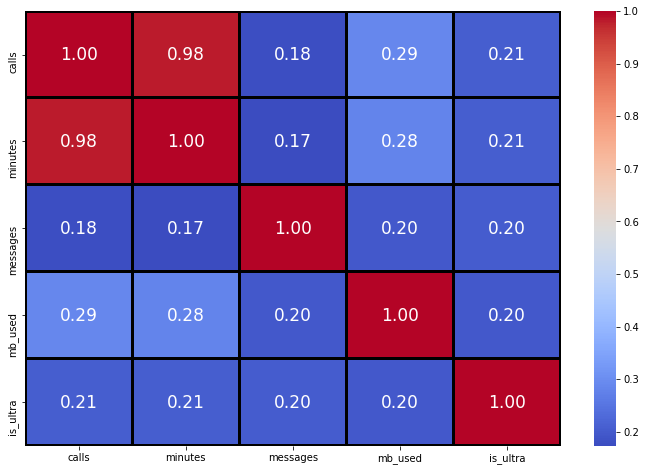

In [6]:
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(),
            annot=True,
            annot_kws={'size': 17},
            fmt='.2f',
            cmap='coolwarm',
            linewidths=2,
            linecolor='black')
plt.show()

## Разбейте данные на выборки

**Учитывая, что спрятанной тестовой выборки у нас нет. Значит, данные разобьём на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разобьём в соотношении 3:1:1.**

In [7]:
# разобьём данные на признаки и целевой признак
X = df.drop(['is_ultra'], axis=1)
y = df['is_ultra']

In [8]:
X.shape, y.shape

((3214, 4), (3214,))

*Задаём пропорцию классов при разделении с помощью параметра stratify функции train_test_split. Мы будем стратифицировать в соответствии распределению по классам в y. Также зафиксируем псевдослучайность параметром random_state*

In [9]:
# разобьём сначала на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=123, stratify=y)

In [10]:
# затем разобьём на тестовый и валидационный наборы
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=123, stratify=y_test)

In [11]:
# проверим длины наших выборок
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1928, 4), (1928,), (643, 4), (643,), (643, 4), (643,))

**Вывод:**      
Мы разбили датасет на признаки, а такжа на обучающую, валидационную и тестовую выборки.

## Исследуйте модели

### Дерево решений

In [36]:
# в цикле переберём значения max_depth от 1 до 12
start = perf_counter()
best_model_tree = None
best_result_tree = 0
best_depth = 0
lst_depth = []
lst_accuracy_val = []
lst_accuracy_tr = []
for depth in range(1, 13):
    model_dt = DecisionTreeClassifier(random_state=123, max_depth=depth)  # создаём модель
    model_dt.fit(X_train, y_train)                                          # обучаем её
    accuracy_tr = model_dt.score(X_train, y_train)
    accuracy_val = model_dt.score(X_val, y_val)
    lst_depth.append(depth)
    lst_accuracy_val.append(accuracy_val)
    lst_accuracy_tr.append(accuracy_tr)
    if accuracy_val > best_result_tree:
        best_model_tree = model_dt
        best_result_tree = accuracy_val
        best_depth = depth
print(f'Accuracy наилучшей модели: {best_result_tree:.4f}\nМаксимальная глубина: {best_depth}')
end = perf_counter()

f"Время выполнения кода: {end-start:.3f} сек"

Accuracy наилучшей модели: 0.8103
Максимальная глубина: 6


'Время выполнения кода: 0.090 сек'

In [13]:
model_dt = DecisionTreeClassifier(random_state=123, max_depth=6)  # создаём модель
model_dt.fit(X_train, y_train)
format(model_dt.score(X_train, y_train), '.4f')

'0.8252'

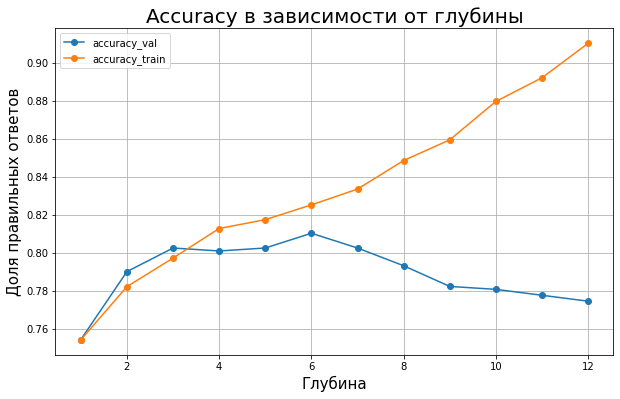

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(lst_depth, lst_accuracy_val, 'o-')
plt.plot(lst_depth, lst_accuracy_tr, 'o-')
plt.grid(True)
plt.legend(['accuracy_val', 'accuracy_train'])
plt.title('Accuracy в зависимости от глубины', fontsize=20)
plt.xlabel('Глубина', fontsize=15)
plt.ylabel('Доля правильных ответов', fontsize=15);

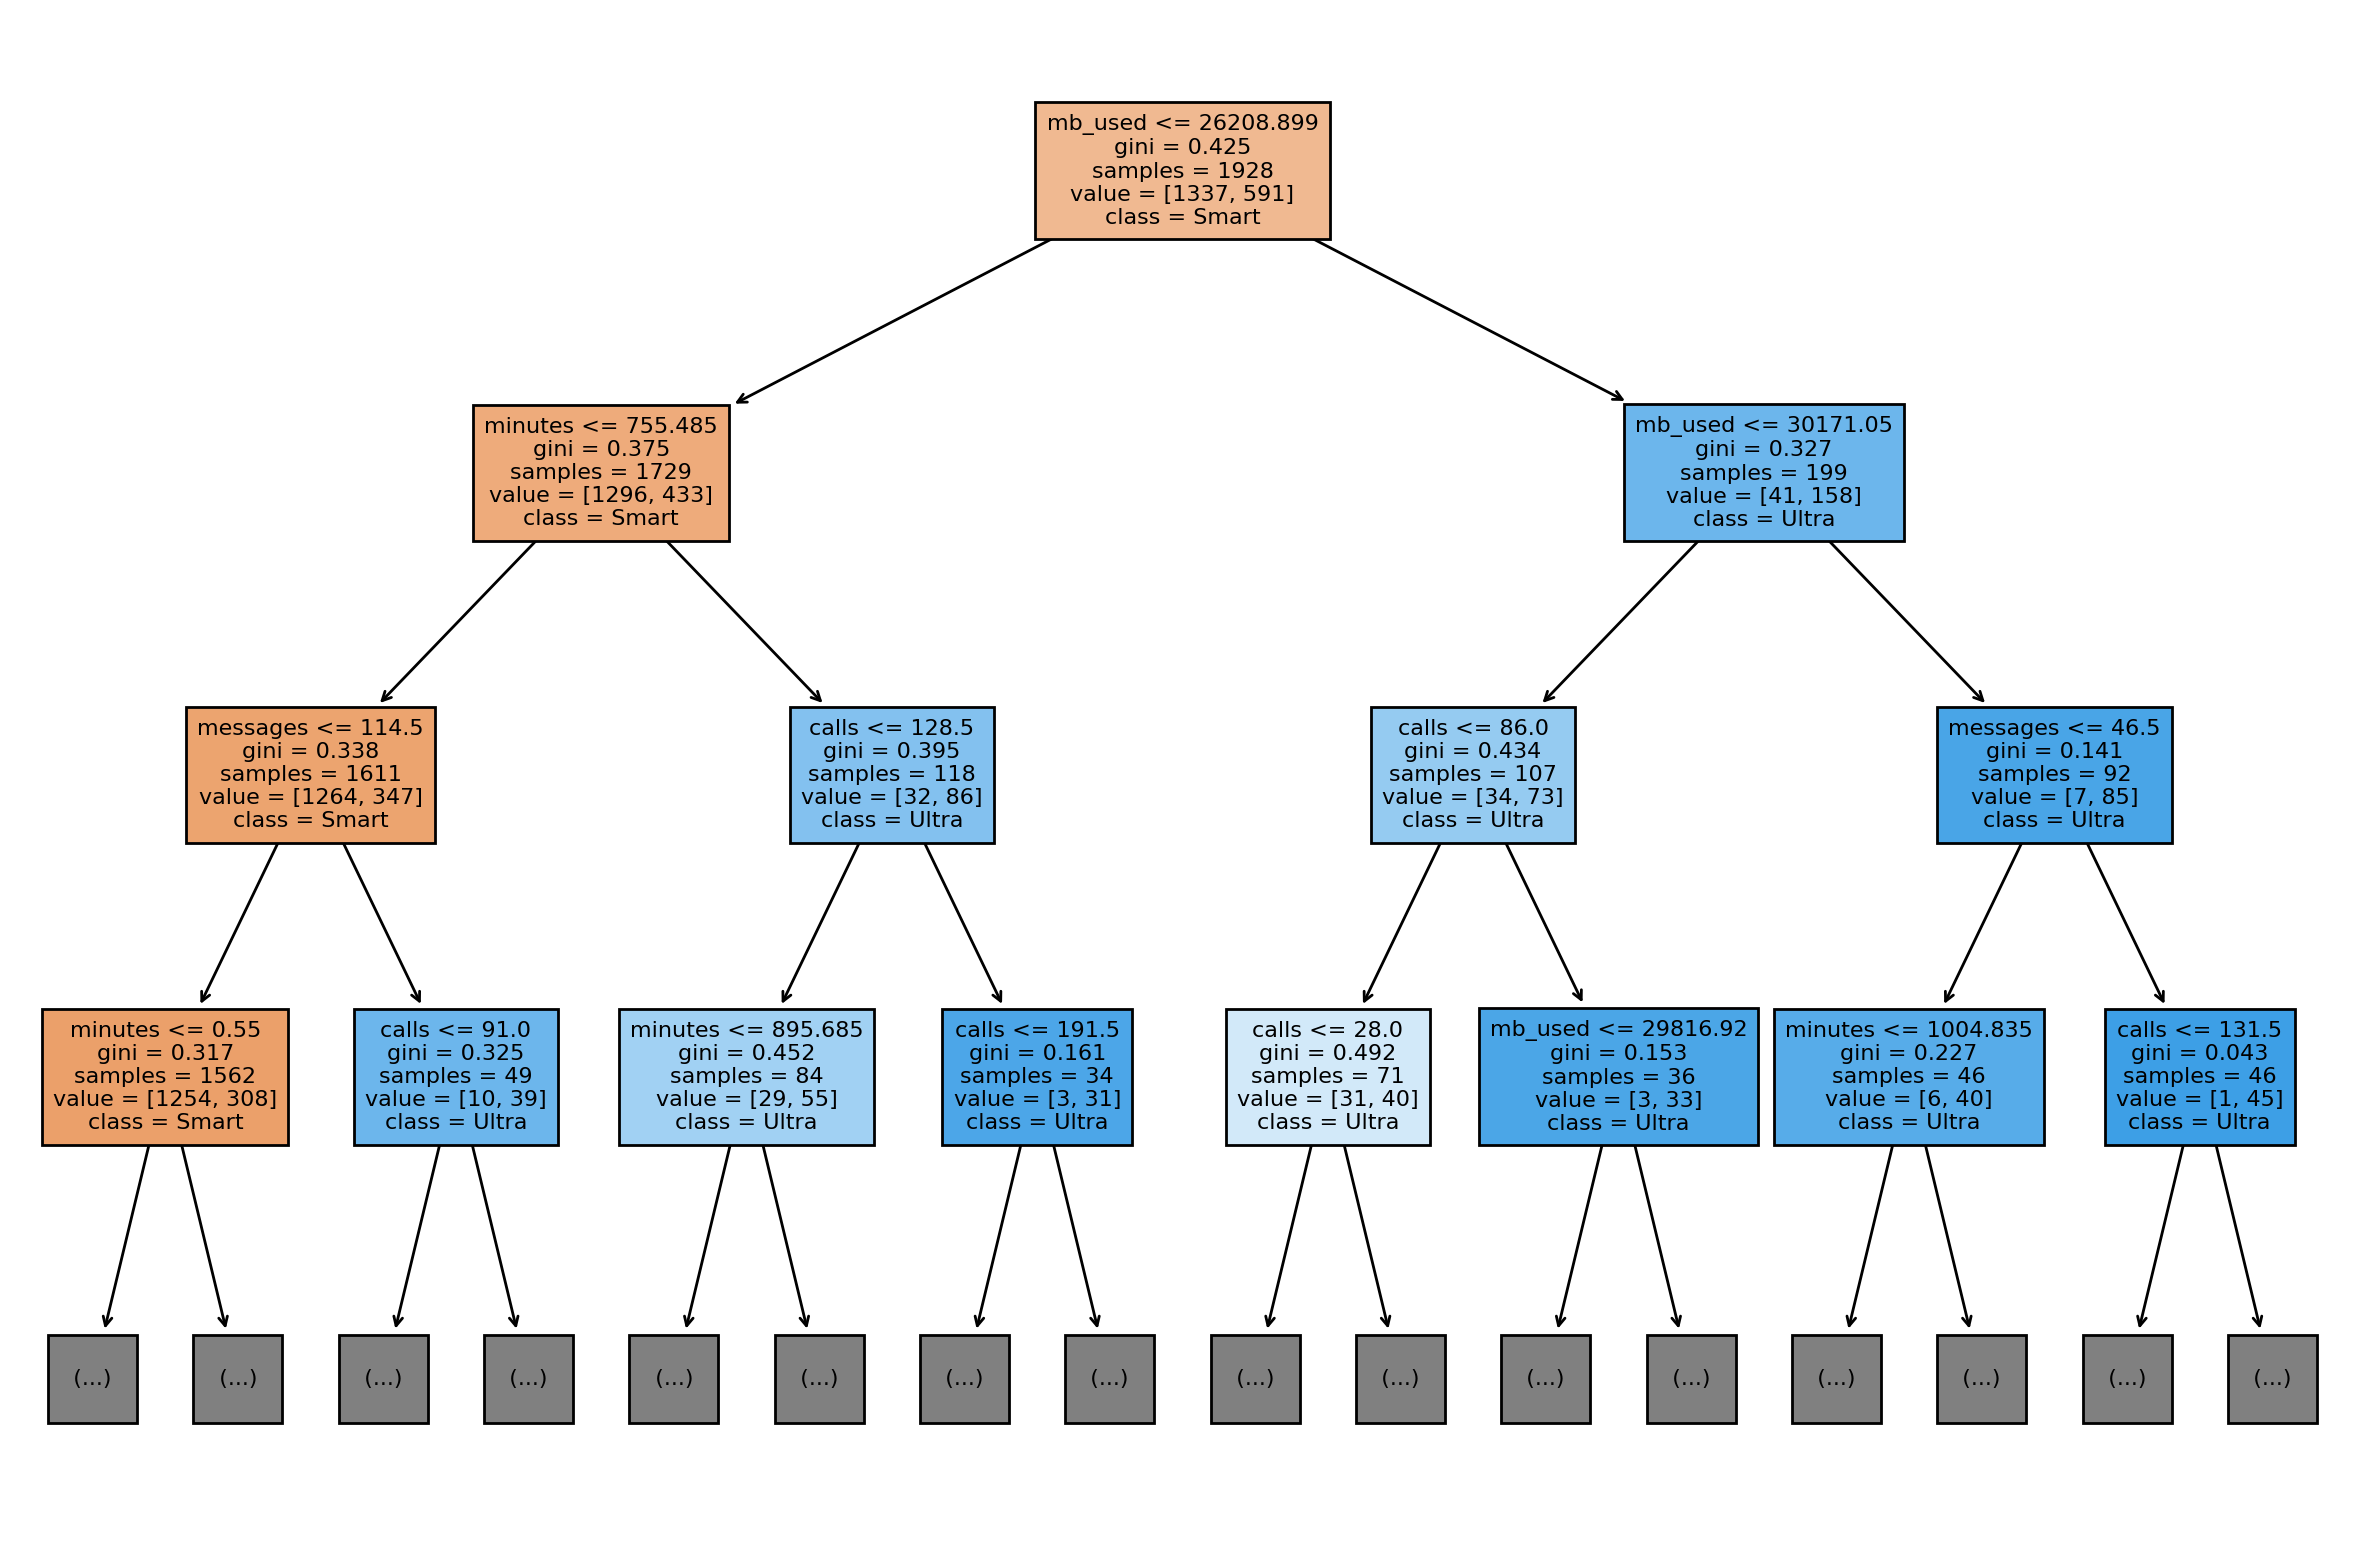

In [60]:
fig = plt.figure(figsize=(15, 10), dpi=200)
_ = tree.plot_tree(best_model_tree, 
               feature_names=X.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 8,
               max_depth = 3)

У модели "дерево решений" наилучшие показатели **при глубине 6 - 0.8103**. Далее модель начинает "переобучаться" и показатели accuracy падают. При глубине 6 на тренировочной выборке показатель accuracy - 0.8252. Скорость решающего дерева высокая и зависит от глубины.

### Случайный лес

In [16]:
best_model = None
best_res = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 51, 10)):
    for depth in range(1, 21):
        model_rf = RandomForestClassifier(random_state=123, n_estimators=est, max_depth=depth)
        model_rf.fit(X_train, y_train)
        res = model_rf.score(X_val, y_val)
        if res > best_res:
            best_model = model_rf
            best_res = res
            best_est = est
            best_depth = depth
print(f'Accuracy наилучшей модели: {best_res:.4f} \nКоличество деревьев: {best_est} \nМаксимальная глубина: {best_depth}')

100%|██████████| 5/5 [00:08<00:00,  1.76s/it]

Accuracy наилучшей модели: 0.8367 
Количество деревьев: 20 
Максимальная глубина: 17


In [17]:
model_rf = RandomForestClassifier(random_state=123, n_estimators=20, max_depth=17)
model_rf.fit(X_train, y_train)
format(model_rf.score(X_train, y_train), '.4f')

'0.9725'

У модели "случайный лес" наилучшие показатели при количестве деревьев **20** и глубине **17** - **0.8367**. При тех же гиперпараметрах на тренировочной выборке показатель accuracy - 0.9606. Случайный лес работает довольно медленно: чем больше деревьев, тем неторопливее работает модель.

### Логическая регрессия

In [18]:
%%time
model_log = LogisticRegression(random_state=123, solver='lbfgs', max_iter=1000) 
model_log.fit(X_train, y_train)
print(f'Accuracy модели равно: {model_log.score(X_val, y_val):.4f}')

Accuracy модели равно: 0.7014
CPU times: user 16.5 ms, sys: 31 µs, total: 16.5 ms
Wall time: 15.2 ms


Модель логической регрессии работает очень быстро, но показатель accuracy (0,7014) довольно низкий.

**Вывод:**  
На этапе обучения моделей и подбора наилучших гиперпараметров на валидационной выборке лучшие результаты показала модель "случайный лес", у неё самый высокий показатель accuracy, хотя, она и самая медленная. Самая быстрая - линейная регрессия, правда, с самым низким показателем accuracy. "Эолотая середина" - это дерево решений(довольно высокий показатель accuracy и высокая скорость работы). 

## Проверьте модель на тестовой выборке

In [19]:
X_train.shape, X_val.shape

((1928, 4), (643, 4))

In [20]:
# создадим новою выборку train + val
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
X_train_val.shape, y_train_val.shape

((2571, 4), (2571,))

In [23]:
model_rf = RandomForestClassifier(random_state=123, n_estimators=20, max_depth=17)
model_rf.fit(X_train, y_train)
print(f'Показатели accuracy на тестовой выборке = {model_rf.score(X_test, y_test):.4f}')

Показатели accuracy на тестовой выборке = 0.7760


**Попробуем обучить на тренировочной + валидационной выборке**

In [24]:
model_rf = RandomForestClassifier(random_state=123, n_estimators=20, max_depth=17)
model_rf.fit(X_train_val, y_train_val)
print(f'Показатели accuracy на тестовой выборке = {model_rf.score(X_test, y_test):.4f}')

Показатели accuracy на тестовой выборке = 0.7978


**Вывод:**   
При проверке на тестовой выборке показатели accuracy оказались несколько ниже, чем на валидационной. Тем не менее впереди оказалась модель "случайный лес" с показателем accuracy - 0.7760. А при соединении выборок результат улучшился до 0.7978.

**precision, recall, F1 и confussion matrix**

In [25]:
model_rf = RandomForestClassifier(random_state=123, n_estimators=20, max_depth=17)
model_rf.fit(X_train_val, y_train_val)
y_pred = model_rf.predict(X_test)
print(f'Показатели accuracy на тестовой выборке = {model_rf.score(X_test, y_test):.4f}')
print(f'Точность на тестовой выборке = {precision_score(y_test, y_pred):.4f}')
print(f'Полнота на тестовой выборке = {recall_score(y_test, y_pred):.4f}')
print(f'F-1 мера на тестовой выборке = {f1_score(y_test, y_pred):.4f}')
confusion_matrix(y_test, y_pred)

Показатели accuracy на тестовой выборке = 0.7978
Точность на тестовой выборке = 0.7410
Полнота на тестовой выборке = 0.5228
F-1 мера на тестовой выборке = 0.6131


array([[410,  36],
       [ 94, 103]])

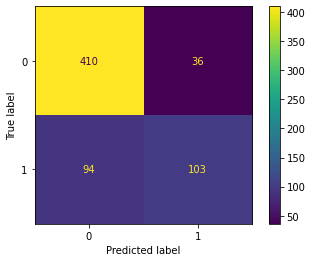

In [26]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## (бонус) Проверьте модели на адекватность

**Нам нужно сравнить модель со случайной, так вы сможете оценить её адекватность, или проверить на вменяемость**

In [27]:
# посмотрим какую долю занимает тариф "Смарт"
df.query('is_ultra == 0')['is_ultra'].count() / df.shape[0]

0.693528313627878

In [28]:
# создадим случайную последовательность из 0 и 1 в соотношении 0,69:0,31
nums = np.random.choice([0, 1], size=643, p=[.69, .31])

In [29]:
print(f'Показатели accuracy на тестовой выборке со случайным целевым признаком = {model_rf.score(X_test, nums):.4f}')

Показатели accuracy на тестовой выборке со случайным целевым признаком = 0.6143


**Наша модель показывает результаты лучше, чем случайная — модель можно считать адекватной.**

проверим датасет на сбалансированность классов в таргете

In [30]:
df.is_ultra.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

**Констатная модель с нулями**

In [31]:
# создадим константную модель
y_constant = pd.Series([0]*len(y_test))
y_constant.shape

(643,)

In [32]:
accuracy_constant = accuracy_score(y_test, y_constant)
print(f'Показатели accuracy констатной модели = {accuracy_constant:.4f}')

Показатели accuracy констатной модели = 0.6936


Показатели accuracy RF выше, чем у констатной модели - модель можно считать адекватной.

**Использование Dummy Models**

In [33]:
model_dummy = DummyClassifier(strategy="most_frequent", random_state=123)
model_dummy = model_dummy.fit(X_train_val, y_train_val).score(X_train_val, y_train_val)
print(f'Показатели accuracy модели Dummy = {model_dummy:.4f}')

Показатели accuracy модели Dummy = 0.6935


Показатели accuracy RF выше, чем у модели Dummy - модель можно считать адекватной.

**Общий вывод:**    
        
 1. Предобработка не потребовалась.
 2. Мы разбили датасет на признаки, а такжа на обучающую, валидационную и тестовую выборки.
 3. Обучили и проанализировали три модели - "дерево решений", "случайный лес" и "логическая регрессия".
 4. При проверке на тестовой выборке показатели accuracy оказались несколько ниже, чем на валидационной.
 5. Проверили на вменяемость - модель можно считать адекватной.           
                    
**Лучшие результаты показала модель "случайный лес" (и на валидационной, и на тестовой выборках). Мы построили модель для задачи классификации, которая выберет подходящий тариф с долей правильных ответов = 0.7978.**